In [1]:
import torch
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import random

In [2]:
from layers import CompressionLayer, QuantizationLayer, FeatureSelectionLayer, HardQuantizationLayer
from models import MultiLayerPerceptron
from datasets import get_dataloader
from training_utils import train_model, eval_val, eval_quantization

In [3]:
from joblib import Parallel, delayed

## Load California Housing

In [4]:
dataset = 'California_Housing'
train_loader, val_loader, test_loader = get_dataloader(dataset = dataset)

### Grid Search for DNN

In [11]:
hidden_neurons = [128, 256, 512, 1024]
max_hidden_layers = 8
neuron_combinations = [[hidden_neuron] for hidden_neuron in hidden_neurons]
neuron_combination_dict = {1: neuron_combinations}
neuron_combinations = []
for current_layers in range(2,max_hidden_layers + 1):
    current_lists = neuron_combination_dict.get(current_layers-1)
    new_lists = []
    for current_list in current_lists:
        for hidden_neuron in hidden_neurons:
            new_list = current_list + [hidden_neuron]
            ## Only add new_list, if it first goes up in neurons and then down
            # if (np.diff(np.sign(np.diff(np.array(new_list)))) <= 0).all() & np.count_nonzero(np.diff(np.sign(np.diff(np.array(new_list))))) <=1:
            ## Only add new_list, if it first goes up in neurons and then down and only has 2 values    
            if ((np.diff(np.sign(np.diff(np.array(new_list)))) <= 0).all()) & (np.count_nonzero(np.diff(np.sign(np.diff(np.array(new_list))))) <=2) & (len(np.unique(np.array(new_list))) <= 3):
                new_lists.append(new_list)
    neuron_combination_dict.update({current_layers: new_lists})
    if current_layers > 3:
        neuron_combinations += new_lists

print(len(neuron_combinations))

286


In [13]:
device = 'cuda'

In [12]:
def random_search_dnn(n_steps = 10, optimize_dict = {}, device = 'cpu'):
    
    # Define default hyperparameters
    weight_decay =  0
    learning_rate = 0.001
    neuron_combination = [256,256]
    num_epochs = 30
    add_noise = False

    # Lists to store results
    random_search_losses = []
    hyperparameter_dict = {
        'weight_decay': [],
        'learning_rate': [],
        'architecture': [],
        'num_epochs': [],
        'add_noise': []}
    

    # Perform random search
    for _ in tqdm(range(n_steps)):
        for key, value in optimize_dict.items():
            if key == 'weight_decay':
                weight_decay = random.choice(value)
            elif key == 'learning_rate':
                learning_rate = random.choice(value)
            elif key == 'neuron_combination':
                neuron_combination = random.choice(value)
            elif key == 'num_epochs':
                num_epochs = random.choice(value)    
            elif key == 'add_noise':
                add_noise = random.choice(value)    
            else:
                raise ValueError(f"Unknown hyperparameter: {key}")
            
        architecture = [8] + neuron_combination + [1]
        hyperparameter_dict['weight_decay'].append(weight_decay)
        hyperparameter_dict['learning_rate'].append(learning_rate)
        hyperparameter_dict['architecture'].append(neuron_combination)
        hyperparameter_dict['num_epochs'].append(num_epochs)
        hyperparameter_dict['add_noise'].append(add_noise)

        # Create and train model
        model = MultiLayerPerceptron(architecture)
        model.to(device)
        criterion = nn.MSELoss()
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
        
        best_val_loss = train_model(model, num_epochs=num_epochs,
                    train_loader=train_loader, test_loader=test_loader,
                    optimizer=optimizer, criterion=criterion, has_quantization_layer=False,
                    train_quantization_layer=False, print_result=False,
                    add_noise=add_noise, device=device)

        val_loss = eval_val(model=model,
                val_dataloader=test_loader,
                criterion=criterion, device = device)
        
        random_search_losses.append(best_val_loss)
    # Create DataFrame with results
    results_df = pd.DataFrame({
        'Architecture': hyperparameter_dict['architecture'],
        'Loss': random_search_losses,
        'Weight Decay': hyperparameter_dict['weight_decay'],
        'Learning Rate': hyperparameter_dict['learning_rate'],
        'Num Epochs': hyperparameter_dict['num_epochs'],
        'Add Noise': hyperparameter_dict['add_noise']

    })
    results_df = results_df.sort_values('Loss')  # Sort by loss ascending    
    return results_df

In [13]:
results_df = random_search_dnn(n_steps = 50,
                  optimize_dict=
                  {'weight_decay': [0, 0.0001],
                   'learning_rate': [0.001, 0.0001],
                     'add_noise': [False, True],
                   'neuron_combination': neuron_combinations,
                   'num_epochs': [30]},
                   device = device)

100%|██████████| 50/50 [17:51<00:00, 21.44s/it]


In [14]:
results_df.head()

,Architecture,Loss,Weight Decay,Learning Rate,Num Epochs,Add Noise
8,"[512, 512, 512, 512, 512, 512, 512, 512]",0.262299,0.0000,0.001,30,False
44,"[256, 1024, 1024, 1024, 256]",0.263791,0.0000,0.001,30,False
45,"[256, 512, 512, 512, 512, 512, 512, 512]",0.267422,0.0001,0.001,30,False
9,"[512, 512, 512, 512, 512, 256]",0.270647,0.0000,0.001,30,False
14,"[256, 1024, 1024, 1024, 1024, 1024, 256]",0.270724,0.0000,0.001,30,False


In [ ]:
results_df.to_csv(f'results/{dataset}/random_search_results_comparison.csv', index=False)

## Try out single architecture

In [5]:
num_features = 8
n_bits = 4
n_thresholds = 8*(2**n_bits-1)
architecture = [n_thresholds,256,256,256,1]

learning_rate = 0.0001
weight_decay = 0.0001
num_epochs = 70
device = 'cuda'

In [6]:
val_losses = []
for f in tqdm(range(1)):
    mlp_first = MultiLayerPerceptron(n_neurons=[8,n_thresholds], activation=nn.Sigmoid)
    mlp = MultiLayerPerceptron(n_neurons=architecture, activation=nn.LeakyReLU)

    model = nn.Sequential(mlp_first, mlp)
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    best_val_loss = train_model(model=model, train_loader=train_loader, num_epochs=num_epochs,
                                test_loader=val_loader, optimizer=optimizer,
                                criterion=criterion, has_quantization_layer=False,
                                train_quantization_layer=False, device=device,
                                print_result=False, add_noise=False)
    val_loss = eval_val(model=model, val_dataloader=val_loader)
    val_losses.append(val_loss)
print(f'Validation loss: {np.mean(val_losses)}')    

100%|██████████| 1/1 [01:05<00:00, 65.62s/it]


In [7]:
np.min(val_losses)

0.2773799025095426

{'whiskers': [<matplotlib.lines.Line2D at 0x7fcb451cb2f0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcb451cb650>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcb451caff0>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcb451cbe00>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcb451cc230>],
 'means': []}

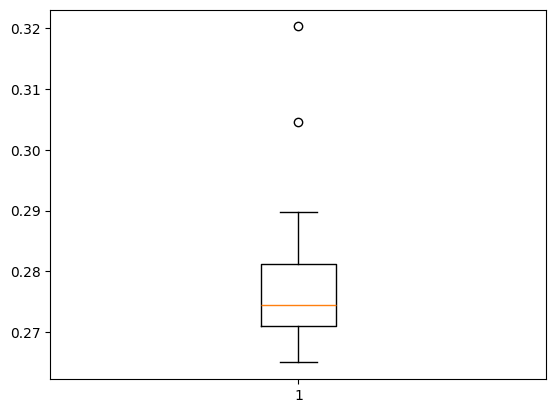

In [23]:
plt.boxplot(val_losses)

In [26]:
print('Validation Losses with Sigmoid in first Layer')
val_losses

Validation Losses with Sigmoid in first Layer


[0.28656715853856163,
 0.2728579139480224,
 0.2792910704245934,
 0.2794373801121345,
 0.2672399475024297,
 0.2730599497373287,
 0.27206318928645207,
 0.2712945955303999,
 0.27391700515380274,
 0.30453256437411674,
 0.28968387154432446,
 0.2684798029752878,
 0.32031629727436944,
 0.2674663128761145,
 0.2785183915725121,
 0.28973103715823245,
 0.2751123506289262,
 0.2650085992538012,
 0.2701992358152683,
 0.2758473447882212]

In [ ]:
val_losses_sigmoid = []
for f in tqdm(range(20)):
    mlp_first = MultiLayerPerceptron(n_neurons=[8,n_thresholds], activation=nn.Sigmoid)
    mlp = MultiLayerPerceptron(n_neurons=architecture, activation = nn.ReLU)

    model = nn.Sequential(mlp_first, mlp)
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
    best_val_loss = train_model(model=model, train_loader=train_loader, num_epochs=num_epochs,
                                test_loader=val_loader, optimizer=optimizer,
                                criterion=criterion, has_quantization_layer=False,
                                train_quantization_layer=False, device=device,
                                print_result=False, add_noise=False)
    # val_loss = eval_val(model=model, val_dataloader=val_loader)
    val_losses_sigmoid.append(best_val_loss)

100%|██████████| 20/20 [12:19<00:00, 36.98s/it]


{'whiskers': [<matplotlib.lines.Line2D at 0x7fcb44569fa0>,
 'caps': [<matplotlib.lines.Line2D at 0x7fcb445685c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x7fcb44518380>],
 'medians': [<matplotlib.lines.Line2D at 0x7fcb4456b980>],
 'fliers': [<matplotlib.lines.Line2D at 0x7fcb4456b110>],
 'means': []}

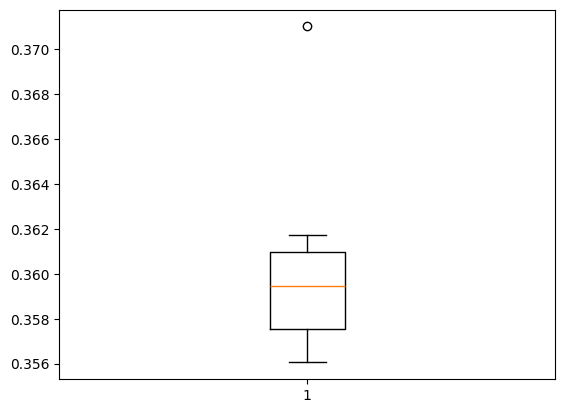

In [28]:
plt.boxplot(val_losses_sigmoid)

In [29]:
print('Validation Losses with Sigmoid in all Layers')
val_losses_sigmoid

Validation Losses with Sigmoid in all Layers


[0.36006407623107617,
 0.3570239990949631,
 0.36099354257950417,
 0.3710177265680753,
 0.36172677966264577,
 0.36107991773348586,
 0.3566009817215113,
 0.3560534140238395,
 0.35637736389270197,
 0.35729563259161434,
 0.3600355334006823,
 0.35871055057415596,
 0.36096294613984914,
 0.3603145388456491,
 0.361515961931302,
 0.359696039557457,
 0.359229822571461,
 0.35760368888194743,
 0.3579173798744495,
 0.35825078372771924]